In [5]:
import timeatlas as ta
from timeatlas import TimeSeries, Metadata
from timeatlas import models
from pandas import Series, DatetimeIndex
import pandas as pd
import os
from pathlib import Path
import fbprophet

---
# Models

How to create models with TimeAtlas? At first let's create a TimeSeries.

In [7]:
index = DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04'])
my_series = Series([0.4, 1.0, 0.7, 0.6], index=index)
ts = TimeSeries(my_series)
ts

## Grammar

Some definitions:

- `time series` : self-explanatory, i.e. the TimeSeries object
- `horizon` : the duration to predict after the last value of the time series
- `frequency`: the number of values per unit of time. Usually, the frequency is given in Pandas offset aliases (https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

```
                                horizon
   |-------------------------|- - - - - -|
                             |||||||||||||
           time series         frequency

```

In [ ]:
m = models.Prophet()

In [ ]:
m.fit(ts)

In [ ]:
Y_hat = m.predict('4 days')

In [ ]:
m.X_train.plot()
Y_hat.plot()

# NN-Models

### MLP Classification

In [4]:
from pandas import Series, DatetimeIndex
from torch.utils.data import DataLoader
from timeatlas import TimeSeriesDataset, TimeSeries
from timeatlas.models.NN.dataloader import TimeSeriesClassificationDataset

Creating some data to show the concept of LSTM classification in timeatlas

In [5]:
index = DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04'])
my_series = Series([0.4, 1.0, 0.7, 0.6], index=index)
my_series2 = Series([1.0, 2.1, 1.7, 1.6], index=index)
ts = TimeSeries(my_series)
ts2 = TimeSeries(my_series2)
ts.label, ts2.label = 1, 2
tsd = TimeSeriesDataset(data=[ts, ts2])

In [6]:
dataset = TimeSeriesClassificationDataset(tsd)
dataloader = DataLoader(dataset, batch_size=2)

dataset.data

array([[0.4, 1. , 0.7, 0.6],
       [1. , 2.1, 1.7, 1.6]])

Normalizations of the dataset

In [7]:
dataset.min_max_norm()


array([[0.        , 0.35294118, 0.17647059, 0.11764706],
       [0.35294118, 1.        , 0.76470588, 0.70588235]])

In [8]:
dataset.z_score_norm()

array([[-1.31436046, -0.24505026, -0.77970536, -0.95792373],
       [-0.24505026,  1.71535179,  1.00247832,  0.82425995]])

In [9]:
dataloader

THE CLASSIFICATION IS NOT IMPLEMENTED YET

In [10]:
for i in dataloader:
    print(i)

[tensor([[0.4000, 1.0000, 0.7000, 0.6000],
        [1.0000, 2.1000, 1.7000, 1.6000]], dtype=torch.float64), tensor([1, 2])]


### LSTM Prediction

Prediciton of the future steps using a LSTM model.

In [1]:
from pandas import Series, DatetimeIndex
from torch.utils.data import DataLoader
from timeatlas import TimeSeriesDataset, TimeSeries
from timeatlas.models import LSTMExe
from timeatlas.models import LSTMPredict
from timeatlas.models.NN import TimeSeriesPredictionDataset

import torch.nn as nn
import torch


import numpy as np
import datetime

Creating some data to show the concept of LSTM prediction in timeatlas

In [2]:
index = DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04'])
my_series = Series([0.4, 1.0, 0.7, 0.6], index=index)
ts = TimeSeries(my_series)
tsd = TimeSeriesDataset(data=[ts, ts])

Creating the dataset and the dataloader

In [3]:
dataset = TimeSeriesPredictionDataset(data=tsd, n=3)
dataloader = DataLoader(dataset, batch_size=2)
dataset.data

array([[0.4, 1. , 0.7],
       [0.4, 1. , 0.7]])

Creating an instance for the LSTM. Here we make the big difference between the workflow of classification, prediction etc.


In [4]:
model = LSTMPredict(n_features=1, n_hidden=10, seq_len=3, n_layers=10, dropout=0.1, horizon=1).double()


The class `LSTM` is where we `fit` model and `predict` the new values. We need to add a optimizer from PyTorch `optim`and a loss function either from PyTorch or writen by yourself.

In [5]:
NN = LSTMExe(model=model, epochs=100, optimizer=torch.optim.Adam, loss_function=nn.MSELoss(), lr=0.001)
model

Prediction(
  (lstm): LSTM(1, 10, num_layers=10, dropout=0.1)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [6]:
NN.fit(dataloader)

epoch:   0 loss: 0.66203237
epoch:  10 loss: 0.60827542
epoch:  20 loss: 0.55400575
epoch:  30 loss: 0.49488815
epoch:  40 loss: 0.43071164
epoch:  50 loss: 0.36785459
epoch:  60 loss: 0.28504256
epoch:  70 loss: 0.19262113
epoch:  80 loss: 0.12262478
epoch:  90 loss: 0.02899924
epoch:  99 loss: 0.0041826609


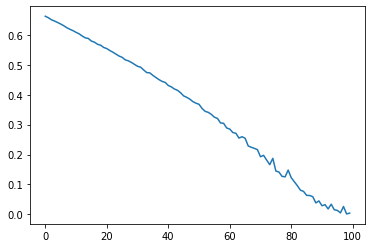

In [11]:
import matplotlib.pyplot as plt

plt.plot(NN.loss)

Create the testset and dataloader. Make a prediction

In [9]:
testset = DataLoader(dataset, batch_size=1)
NN.predict(horizon=1, testset=testset)

[tensor([[1.2939]], dtype=torch.float64, grad_fn=<AddmmBackward>),
 tensor([[1.2999]], dtype=torch.float64, grad_fn=<AddmmBackward>)]